In [9]:
import os
import csv
import gzip
import pickle
import datetime
import requests
import numpy as np
import pandas as pd
from scipy import interpolate

import jdcal
import astropy
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import coordinates

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output, display

In [10]:
out = 'out\\'
figsave_format = 'png'
figsave_dpi = 200

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
seaborn_cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Get Simad results with astroquery on specific star

In [11]:
from astroquery.simbad import Simbad

In [12]:
star_name = 'Betelgeuse'
astroquery_results = Simbad.query_object(star_name)

# Export Ra and Dec info
star_ra = str(astroquery_results[0]['RA'])
star_dec = str(astroquery_results[0]['DEC']).replace('+','').replace('-','')

In [13]:
astroquery_results

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
* alf Ori,05 55 10.3053,+07 24 25.430,9,9,9.040,5.720,90,A,O,2007A&A...474..653V


## Load star data

In [34]:
data_file = 'data\\betelgeuse.csv'

In [35]:
# Count lines in .csv
with open(data_file, "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    line_count = 0

    for row_i in csv_reader:
        line_count += 1

    print("Processed {} lines.".format(line_count-1))

Processed 2851 lines.


In [36]:
with open(data_file, 'r') as f:
    star_data = pd.read_csv(f)

available_bands = list(set(star_data['Band'].values))

In [37]:
star_data[(star_data['Band'] == 'V')]

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.458772e+06,0.647,0.005,NaN,V,VOL,NaN,GAM ORI = HD35468,ZET ORI = HD37742,NaN,...,1.64,1.830,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
1,2.458772e+06,0.660,0.005,NaN,V,VOL,NaN,GAM ORI = HD35468,ZET ORI = HD37742,NaN,...,1.64,1.820,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
8,2.458779e+06,0.673,0.006,NaN,V,VOL,NaN,GAM ORI = HD35468,ZET ORI = HD37742,NaN,...,1.64,1.850,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
9,2.458779e+06,0.691,0.009,NaN,V,VOL,NaN,GAM ORI = HD35468,ZET ORI = HD37742,NaN,...,1.64,1.833,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
16,2.458781e+06,0.669,0.011,NaN,V,VOL,NaN,GAM ORI = HD35468,ZET ORI = HD37742,NaN,...,1.64,1.885,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,2.458919e+06,1.316,0.010,NaN,V,RZD,NaN,ENSEMBLE,NaN,200224,...,NaN,NaN,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
2762,2.458919e+06,1.301,0.010,NaN,V,RZD,NaN,ENSEMBLE,NaN,200224,...,NaN,NaN,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
2770,2.458920e+06,1.274,0.004,NaN,V,CTOA,NaN,SAO 112958,SAO 113186,PEP,...,-3.930,-2.047,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN
2785,2.458920e+06,1.04,0.010,NaN,V,CTIA,NaN,000-BBJ-738,000-BBK-574,X25071BPL,...,-15.61,-15.710,NaN,ALF ORI,AAVSO,STD,NaN,NaN,NaN,NaN


## Date formatting

In [38]:
import matplotlib.dates as mdates

# FUTURE WARNING: EXPLICIT CONVERTER DECLARATION REQUIRED
# WHEN PLOTTING 'DATETIMES' FROM PANDAS DATAFRAMES
# USING MATPLOTLIB
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Format displayed ticks as years
dates_fmt = mdates.DateFormatter('%D')

In [39]:
# Convert Julian Calendar Dates to Gregorian dates
MJD_0 = 2400000.5
dates = star_data[(star_data['Band'] == 'V')]['JD'].values - MJD_0

greg_dates = []
for date in dates:
    date = jdcal.jd2gcal(MJD_0, date)
    
    time = date[3] * 24 * 60
    hrs, sec = divmod(time * 60, 3600)
    mins, sec = divmod(sec, 60)
    sec = int(sec)

    date = '{0:02}-{1:02}-{2:02} {3:02.0f}:{4:02.0f}:{5:02.0f}'.format(date[0], date[1], date[2],
                                                                       hrs, mins, sec)
    greg_dates.append(pd.Timestamp(date))

In [40]:
def set_colors(arr, cmap, vmin=0, vmax=1):
    
    assert vmin >= 0, "Parameter \'vmin\' should be >=0 !"
    assert vmax <= 1, "Parameter \'vmax\' should be <=1 !"
    
    m = interpolate.interp1d([np.min(arr), np.max(arr)], [vmin, vmax])
    colors = cmap(m(arr))
    
    return colors

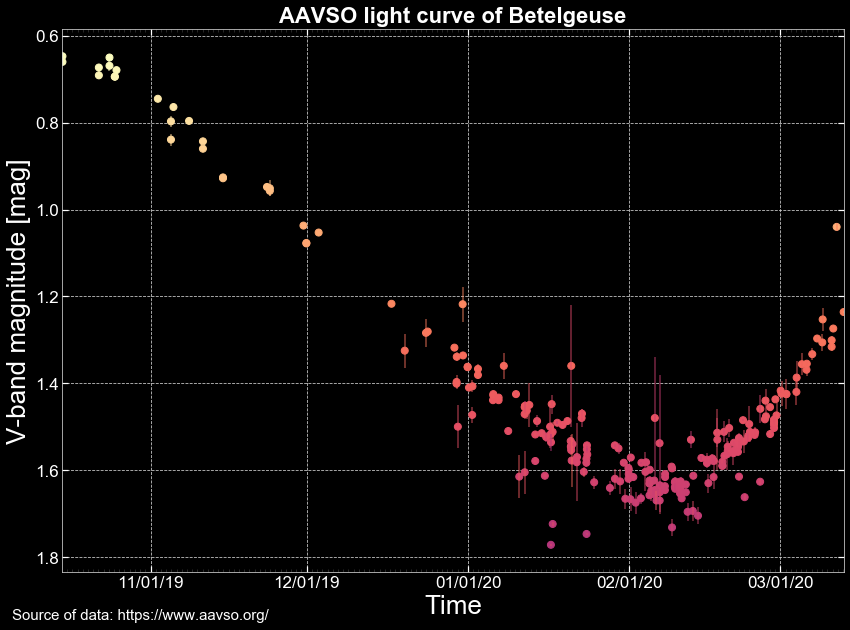

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,10),
                         facecolor='black', subplot_kw=dict(facecolor='black'))

axistitlesize = 22
axisticksize = 17
axislabelsize = 26
axislegendsize = 23

sradius = 7

# Magnitude
axes.invert_yaxis()

v_mag = np.array(star_data[(star_data['Band'] == 'V')]['Magnitude'].values, dtype='float64')
v_mag_err = np.array(star_data[(star_data['Band'] == 'V')]['Uncertainty'].values, dtype='float64')

colors = set_colors(v_mag, cmap=cm.magma_r, vmin=0, vmax=0.5)

axes.scatter(greg_dates, v_mag,
             color=colors, s=sradius**2)
axes.errorbar(greg_dates, v_mag, yerr=v_mag_err,
              linestyle='None',
              c=colors, alpha=0.6)

# Source text
axes.text(x=0.1, y=-0.08, s='Source of data: https://www.aavso.org/',
          c='white', fontsize=15, fontweight='book',
          horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
          bbox=dict(facecolor='black', alpha=0.2, lw=0))

axes.set_title('AAVSO light curve of Betelgeuse', fontsize=axistitlesize, fontweight='bold', color='white')

axes.set_xlabel('Time', fontsize=axislabelsize, color='white')
axes.set_ylabel('V-band magnitude [mag]', fontsize=axislabelsize, color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

# Should be placed after setting x-ticks!!!
axes.set_xlim(greg_dates[0], greg_dates[-1])

# DATE FORMATTING SOURCE:
#   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
# Format the ticks by calling the locator instances of matplotlib.dates
axes.xaxis.set_major_locator(mdates.MonthLocator())
axes.xaxis.set_major_formatter(dates_fmt)
axes.xaxis.set_minor_locator(mdates.DayLocator())

plt.savefig(out + 'betelgeuse.png',
            format=figsave_format, dpi=figsave_dpi,
            pad=5,
            facecolor='black', edgecolor='black')

plt.show()

Betelgeuse, or α Ori is a red supergiant, semiregular variable star and it is the second brightest star in the Orion constellation. In the past approx. 4 moths its allegedly irregular dimming could be observed even by the naked eye. It is now almost entirely concluded, that this phenomenon was observed due to a large-grain circumstellar dust along our sightline to Betelgeuse[1]. Since the middle of february Betelgeuse slowly started to get brigther again. On this Fig. I've shown the V-band magnitude of Betelgeuse between the 15th of October, 2019 and 15th of March, 2020.

========  
References:
[1]: Levesque, E. M., & Massey, P. (2020). Betelgeuse Just Isn't That Cool: Effective Temperature Alone Cannot Explain the Recent Dimming of Betelgeuse. arXiv preprint arXiv:2002.10463.
  
========
#betelgeuse #variable #star #redgiant #astronomy #tschillaghass